# Project 1

## Excersise 1

Generate our own dataset for the Franke Function, with $x,y\in[0,1]$

Write our own code to perform a standard least square regression analysis usning polynomials in x and y up to fith order.

In [279]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from scipy.stats import norm

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


np.random.seed(np.random.randint(1,1000))

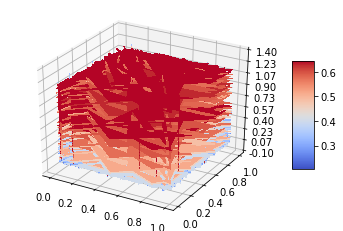

In [193]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

fig = plt.figure()
ax = fig.gca(projection='3d')
num_points = 1000
# Make data.
x = (np.random.uniform(0, 1, num_points))
y =  (np.random.uniform(0, 1, num_points))
x, y = np.meshgrid(x,y)


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [195]:
def FrankeFunction(x, y, sigma = 0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    noise = np.random.normal(0, 1, x.shape[0])
    noise = noise.reshape(x.shape[0],1)

    return (term1 + term2 + term3 + term4).reshape(-1,1)  + sigma*noise

def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)   # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

def least_square(x_value,y_value):
    # Using pinv
    return np.linalg.pinv(x_value.transpose().dot(x_value)).dot(x_value.transpose().dot(y_value))

def plot_errors(x_range_train, x_range_test, y_values_train, y_values_test, title, xlabel_axis, ylabel_axis, graph_label_train, graph_label_test):
    fig = plt.figure(figsize = (20,5))
    plt.xlabel(xlabel_axis)
    plt.ylabel(ylabel_axis)
    plt.title(title)
    plt.plot(x_range_train, y_values_train, label=graph_label_train)
    plt.plot(x_range_test, y_values_test, label=graph_label_test)
    plt.legend()
    plt.show()


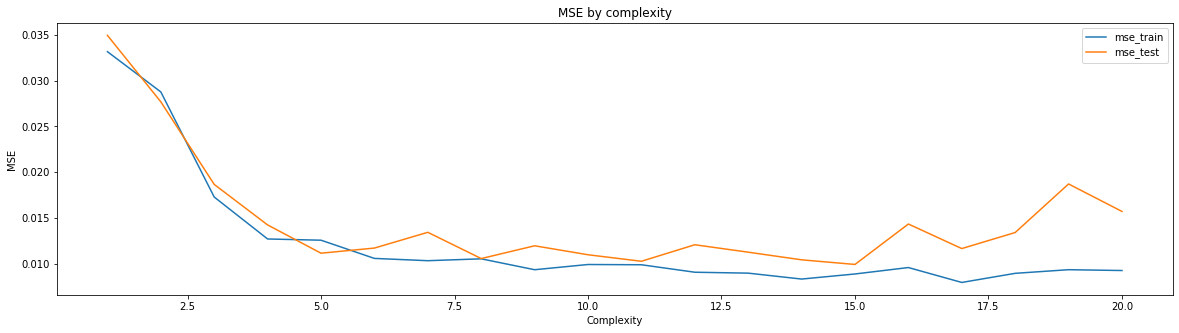

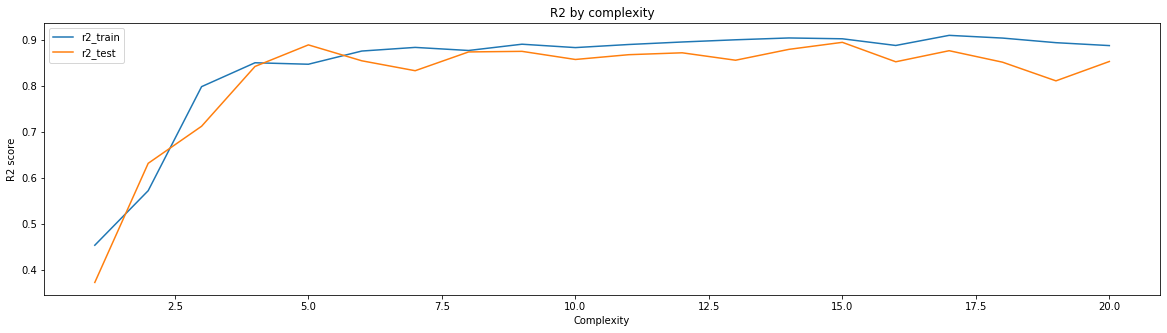

In [249]:
def simple_ols_run(
    x = (np.random.uniform(0, 1, 1000)), 
    y =  (np.random.uniform(0, 1, 1000)), 
    num_points = 1000, 
    complexity = 5, 
    noise = 0, 
    scale = True, 
    plot_mse = False, 
    plot_r2 = False):
    """
    Computes the simples ordinary least square based on the Franke Function
    
    Args:
        stuff
        
    Returns:
        ols_beta: The OLS
    """
    
    if num_points != len(x):
        x = (np.random.uniform(0, 1, num_points))
        y =  (np.random.uniform(0, 1, num_points))
        
        
    MSE_train = []
    MSE_pred = []
    r2_train = []
    r2_pred = []
    
    all_ols_betas = []
    all_xtx_inv = []

    for complexity in range(1,complexity+1):

        #Trying not to sort the x and y's
        z = FrankeFunction(x, y, noise) # Target
        X = create_X(x, y, n=complexity)  # Data

        # True to z instead of y, and same with predictions: z_pred instead of y_pred
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        #scaler = MinMaxScaler(feature_range= [-1,1])
        scaler_in = StandardScaler(with_std=False)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=False)
        scale_z.fit(z_train)
        
# Ridge: fit_intesect = False, da bryr vi oss ikke om intersect

        if scale:
            X_train = scaler_in.transform(X_train)
            X_test = scaler_in.transform(X_test)
            #X_train -= np.mean(X_train)
            #X_test -= np.mean(X_test)
            z_train = scale_z.transform(z_train)
            z_test = scale_z.transform(z_test)


        ols_beta = least_square(X_train, z_train)
        all_ols_betas.append(ols_beta)
        
        xtx = np.linalg.pinv(X_train.transpose().dot(X_train))
        all_xtx_inv.append(xtx)

        z_tilde = X_train.dot(ols_beta)
        z_pred = X_test.dot(ols_beta)


        mse_train = mean_squared_error(z_tilde, z_train)
        MSE_train.append(mse_train)
        mse_test = mean_squared_error(z_pred, z_test)
        MSE_pred.append(mse_test)

        r2_train.append(r2_score(z_tilde, z_train))
        r2_pred.append(r2_score(z_pred, z_test))
    
    if plot_mse:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = MSE_train, 
            y_values_test = MSE_pred,
            title = 'MSE by complexity', 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'MSE',
            graph_label_train = 'mse_train',
            graph_label_test = 'mse_test'
        )

    if plot_r2:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = r2_train, 
            y_values_test = r2_pred,
            title = 'R2 by complexity', 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'R2 score',
            graph_label_train = 'r2_train',
            graph_label_test = 'r2_test'
        )
    
    
    return all_ols_betas, all_xtx_inv

betas, xtx = simple_ols_run(num_points = 1000, complexity = 20, noise = 0.1, plot_mse = True, plot_r2 = True)


### Find confidence interval

In [9]:
def confidence_interval(beta, xtx_inv, confidence):
    """
    Calculates the confidence interval of our parameters beta
    
    Args:
        beta: our parameters
        xtx_inv: (pseudo) inverted of our design matrix transposed multiplied with the design matrix.
        confidence: confidence level
    Returns:
        confidence_interavl: the confidence interval for each of our parameters
    """
    diag_sqrt = np.sqrt(np.diag(xtx_inv))
    
    confidence_interval = [beta-confidence*diag_sqrt, beta+confidence*diag_sqrt]
        
    return np.array(confidence_interval)

betas, xtx = simple_ols_run(num_points = 100000, complexity = 5, noise = 10)
confidence_interval(betas[-1], xtx[-1], 1.96), betas[-1]

(array([[[ 0.00000000e+00, -1.34724334e+00, -1.32627671e+00,
          -6.39083057e+00, -4.99133506e+00, -6.33212726e+00,
          -1.42243647e+01, -1.06087742e+01, -1.05131139e+01,
          -1.41571906e+01, -1.48005354e+01, -1.13572484e+01,
          -1.05390208e+01, -1.12554658e+01, -1.47598048e+01,
          -5.80157265e+00, -5.06307053e+00, -4.94955259e+00,
          -4.94274292e+00, -5.02788223e+00, -5.78935377e+00],
         [ 8.27602777e+00,  6.92878443e+00,  6.94975106e+00,
           1.88519720e+00,  3.28469271e+00,  1.94390051e+00,
          -5.94833689e+00, -2.33274638e+00, -2.23708614e+00,
          -5.88116282e+00, -6.52450761e+00, -3.08122066e+00,
          -2.26299299e+00, -2.97943800e+00, -6.48377704e+00,
           2.47445512e+00,  3.21295724e+00,  3.32647518e+00,
           3.33328485e+00,  3.24814554e+00,  2.48667400e+00],
         [ 4.04611290e+00,  2.69886955e+00,  2.71983619e+00,
          -2.34471767e+00, -9.45222169e-01, -2.28601436e+00,
          -1.01782518e

## Exercise 2

### Plotting Figure 2.11

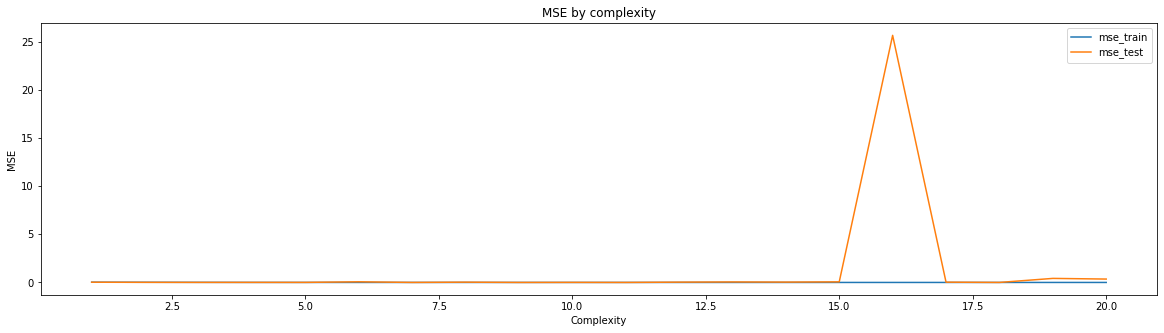

In [5]:
betas, xtx = simple_ols_run(num_points = 100, complexity = 20, noise = 1, plot_mse=True)

## Bias and variance explaination and interpretation

TODO

## Bias-variance trade-off analysis

### Bias-variance trade-off without bootstrap with constant data points

We see that we get no variance, and that the bias = error.

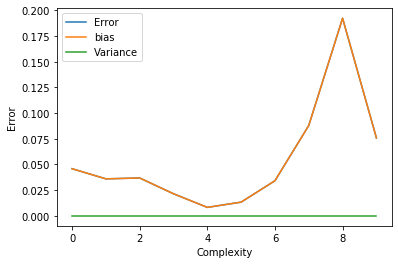

In [239]:
def bias_variance_analysis(reg_func, num_points, max_degree):
    np.random.seed(10)
    # Make data
    x = (np.random.uniform(0, 1, num_points))
    y =  (np.random.uniform(0, 1, num_points))
    z = FrankeFunction(x, y, 0.1) # Target
    
    # Aggregrate results
    error = np.zeros(max_degree)
    bias = np.zeros(max_degree)
    variance = np.zeros(max_degree)
    
    for complexity in range(max_degree):
        
        # Make design matrix
        X = create_X(x, y, n=complexity)
        
        # Split training data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        # Scaling the data
        scaler_in = StandardScaler(with_std=False)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=False)
        scale_z.fit(z_train)
        
        X_train = scaler_in.transform(X_train)
        X_test = scaler_in.transform(X_test)
        z_train = scale_z.transform(z_train)
        z_test = scale_z.transform(z_test)
        
        # Find optimal beta
        beta_opt = reg_func(X_train, z_train)
        
        # Predict
        z_pred = X_test.dot(ols_beta)
        
        # Loss:
        mse_test = mean_squared_error(z_pred, z_test)
        
        # Aggregrate stats:
        error[complexity] = mse_test
        bias[complexity] = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True))**2)
        variance[complexity] = np.mean((z_pred - np.mean(z_pred, axis = 1, keepdims = True))**2)
    
    polydegree =  np.arange(max_degree)
    plt.plot(polydegree, error, label='Error')
    plt.plot(polydegree, bias, label='bias')
    plt.plot(polydegree, variance, label='Variance')
    plt.xlabel("Complexity")
    plt.ylabel("Error")
    
    plt.legend()
    plt.show()
    
    stuff = np.add(bias,variance)
    
bias_variance_analysis(100, 10)

## Bias-variance trade-off with bootstrap and varying number of datapoints

20


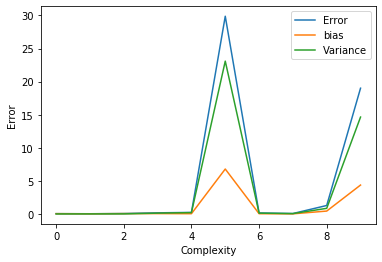

30


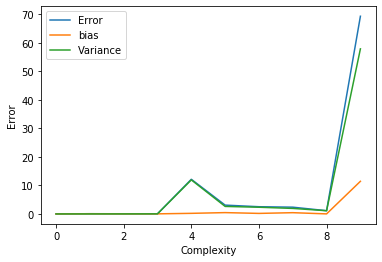

40


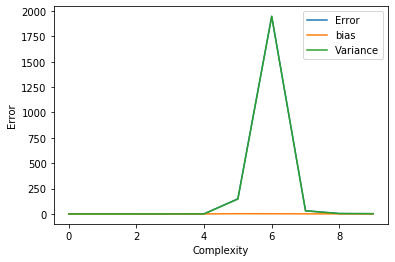

50


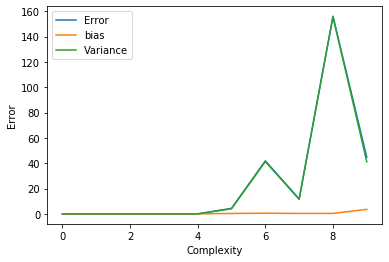

60


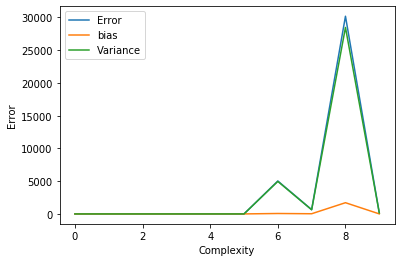

70


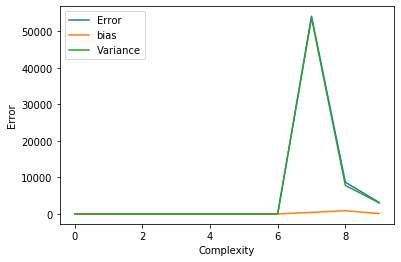

80


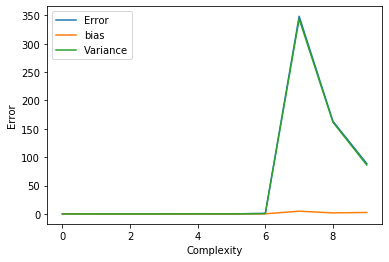

90


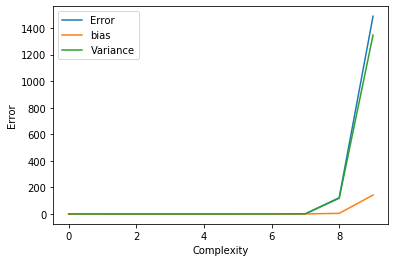

In [319]:
def custom_mse_with_broadcast(y_pred, y_test):
    return np.mean((y_pred - y_test)**2)

def bias_variance_analysis_bootstrap(num_points, max_degree, num_bootstraps, plot = True):
    # Make data
    x = (np.random.uniform(0, 1, num_points))
    y =  (np.random.uniform(0, 1, num_points))
    z = FrankeFunction(x, y, 0.1) # Target
    
    # Aggregrate results
    error = np.zeros(max_degree)
    bias = np.zeros(max_degree)
    variance = np.zeros(max_degree)
    
    for complexity in range(max_degree):
        
        # Make design matrix
        X = create_X(x, y, n=complexity)
        
        # Split training data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        # Scaling the data
        
        scaler_in = StandardScaler(with_std=False)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=False)
        scale_z.fit(z_train)
        
        X_train = scaler_in.transform(X_train)
        X_test = scaler_in.transform(X_test)
        z_train = scale_z.transform(z_train)
        z_test = scale_z.transform(z_test)
        
        # Bootstrap
        z_pred_aggregate = np.empty((z_test.shape[0], num_bootstraps))
        for boot_strap_number in range(num_bootstraps):
            x_sample, y_sample = resample(X_train, z_train)
            # OLS:
            ols_beta = least_square(x_sample, y_sample)
            # Predict
            z_pred = X_test.dot(ols_beta).ravel()
            # Aggregate the predictions
            z_pred_aggregate[:, boot_strap_number] = z_pred
        
        # Loss: Mean of all the bootstrap MSE's
        mse_test = np.mean(custom_mse_with_broadcast(z_pred_aggregate, z_test))
        
        # Aggregrate stats:
        error[complexity] = mse_test
        bias[complexity] = np.mean((z_test - np.mean(z_pred_aggregate, axis=1, keepdims=True))**2)
        variance[complexity] = np.mean((z_pred_aggregate - np.mean(z_pred_aggregate, axis = 1, keepdims = True))**2)
        

    
    if plot:  
        polydegree =  np.arange(max_degree)
        plt.plot(polydegree, error, label='Error')
        plt.plot(polydegree, bias, label='bias')
        plt.plot(polydegree, variance, label='Variance')
        plt.xlabel("Complexity")
        plt.ylabel("Error")
        plt.legend()
        plt.show()
    
    return error
    
for data_points in range(20, 100, 10):
    print(data_points)
    bias_variance_analysis_bootstrap(data_points, 10, data_points)  

# Exercise 3

## K-fold cross-validation

Scaling the data after we split the data, as if we split it before, then the we scale based on all the data instead of just training

In [321]:
def kfold_custom(num_points, num_splits, complexity):
    
    # Create data
    x = (np.random.uniform(0, 1, num_points))
    y =  (np.random.uniform(0, 1, num_points))
    z = FrankeFunction(x, y, 0.1) # Target
    
    X = create_X(x, y, n=complexity)

    # Initialize our kfold
    kfold = KFold(n_splits = num_splits)
    
    # Error
    mse_test_kfold = np.zeros(num_splits)
    
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Training split + scaling
        X_train = X[train_index] - np.mean(X[train_index])
        z_train = z[train_index] - np.mean(z[train_index])

        # Testing split + scaling
        X_test = X[test_index] - np.mean(X[test_index])
        z_test = z[test_index] - np.mean(z[test_index])
        
        # OLS
        ols_beta = least_square(X_train, z_train)
        
        # Prediction
        z_pred = X_test.dot(ols_beta)
        
        mse_test_kfold[i] = mean_squared_error(z_test, z_pred)
        
        
    return np.mean(mse_test_kfold)

    
def cross_validation(num_points, num_folds, max_complexity, plot = False):
    
    mse_per_complexity = np.zeros(max_complexity)
    
    for complexity in range(max_complexity):
        mse_per_complexity[complexity] = kfold_custom(num_points, num_folds, complexity)
    
    if plot:
        polydegree =  np.arange(max_complexity)
        plt.plot(polydegree, mse_per_complexity, label='MSE cross validation' + str(num_folds))
        plt.xlabel("Complexity")
        plt.ylabel("MSE")
        plt.legend()
    
    return mse_per_complexity
        
def full_cross_valid(num_points, min_fold, max_fold, max_complecity, plot = False):
    
    for fold in range(min_fold, max_fold+1):
        cross_validation(num_points, fold, max_complecity)
    
    if plot:
        plt.show()

full_cross_valid(100, 5,10 , 10, plot = True)


### Comparing with SKlearn

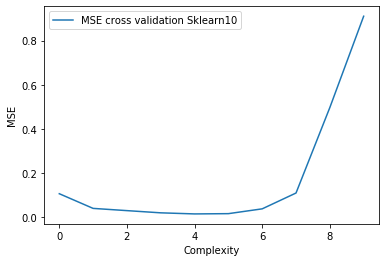

In [303]:
def cross_val_sklearn(num_points, num_folds, max_complexity, plot=False):
    estimated_mse_sklearn = np.zeros(max_complexity)
    
    x = (np.random.uniform(0, 1, num_points))
    y =  (np.random.uniform(0, 1, num_points))
    z = FrankeFunction(x, y, 0.1) # Target
    
    for complexity in range(max_complexity):
        
        linreg = LinearRegression()
        
        X = create_X(x, y, n=complexity)
        
        kfold = KFold(n_splits = num_folds)

        estimated_mse_folds = cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold)

        estimated_mse_sklearn[complexity] = np.mean(-estimated_mse_folds)
        
    polydegree =  np.arange(max_complexity)
    plt.plot(polydegree, estimated_mse_sklearn, label='MSE cross validation Sklearn' + str(num_folds))
    plt.xlabel("Complexity")
    plt.ylabel("MSE")
    plt.legend()
    if plot:
        plt.show()

cross_val_sklearn(100, 10, 10, plot=True)

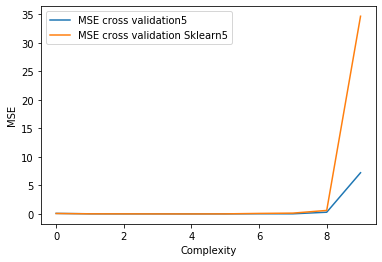

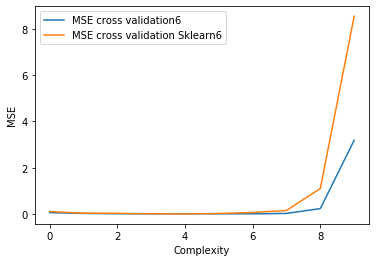

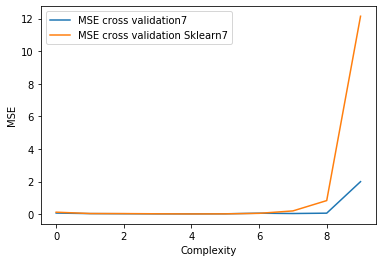

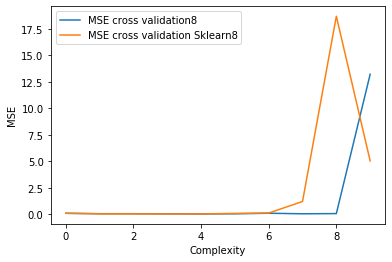

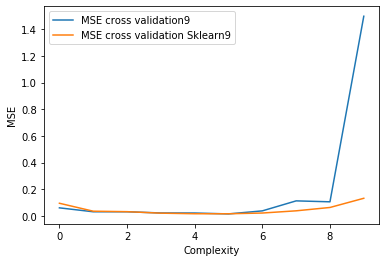

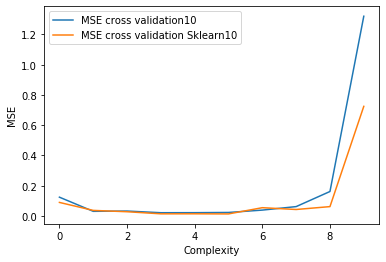

In [309]:
def compare_cross_valid_custom_vs_sklearn():
    for fold in range(5,11):
        full_cross_valid(100, fold,fold,10)
        cross_val_sklearn(100, fold, 10)
        plt.show()

compare_cross_valid_custom_vs_sklearn()

## Compare Cross validation vs. bootstrap for MSE

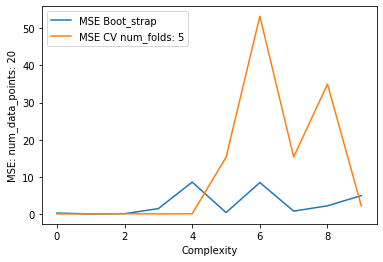

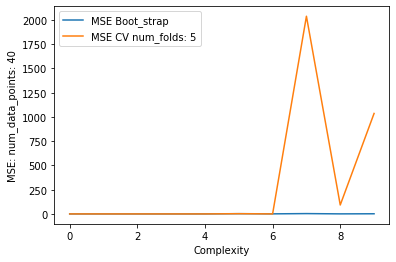

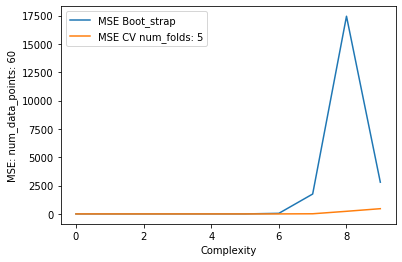

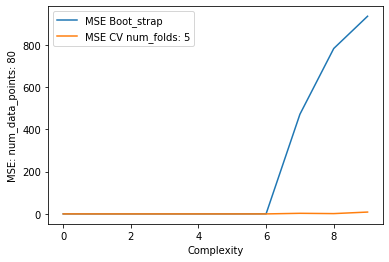

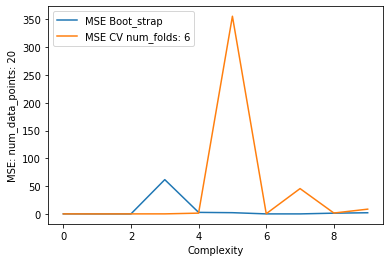

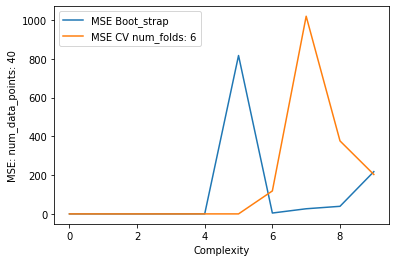

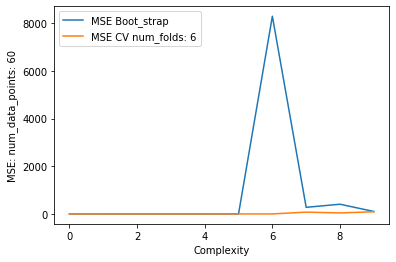

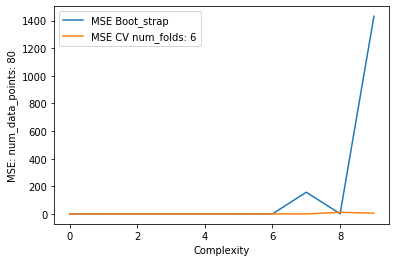

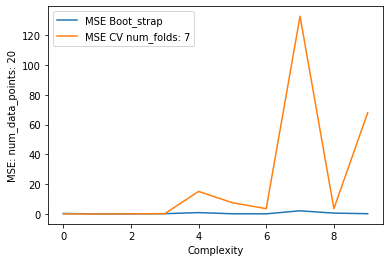

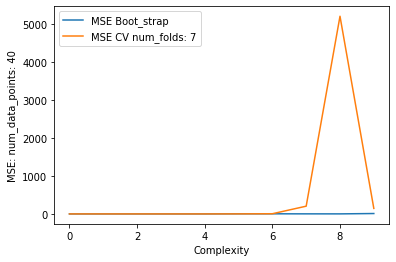

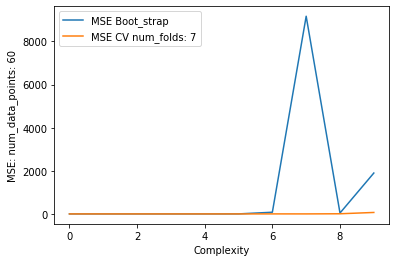

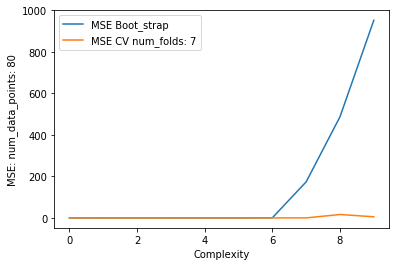

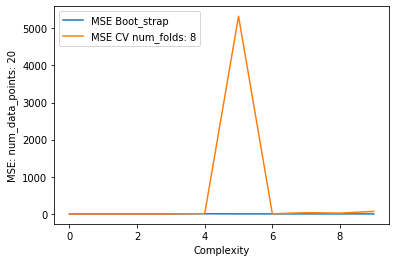

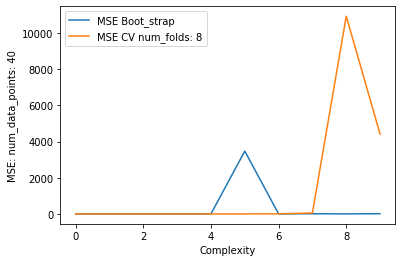

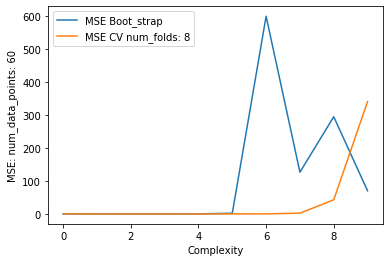

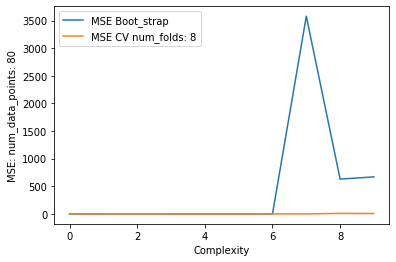

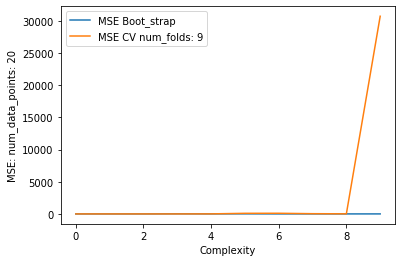

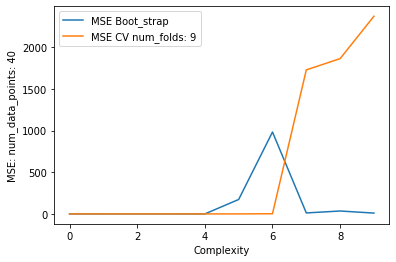

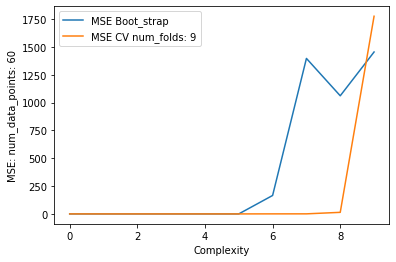

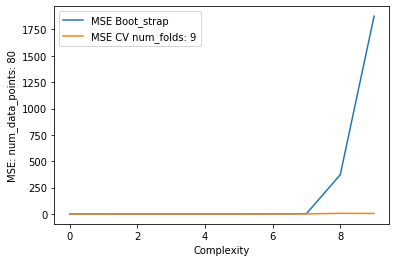

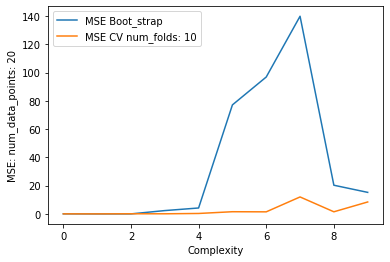

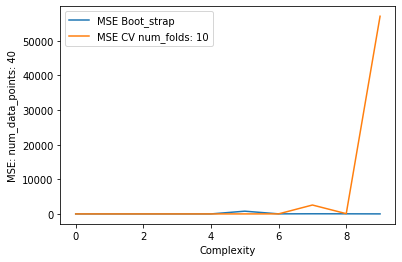

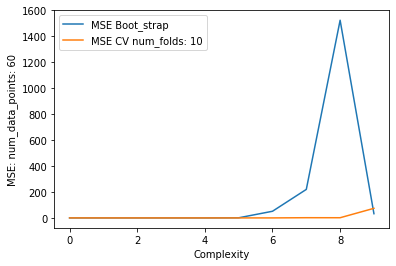

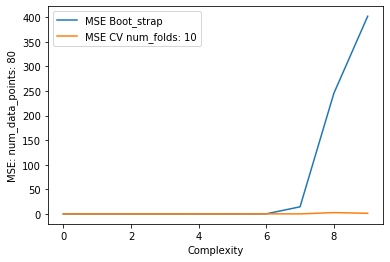

In [331]:
def compare_cv_with_booststrap(max_data_points, max_complexity):
    for fold in range(5,11):
        for num_data_points in range(20,max_data_points, 20):
            bootstrap_mse = bias_variance_analysis_bootstrap(num_data_points, max_complexity, num_data_points, plot = False) 
            cv_mse = cross_validation(num_data_points, fold, max_complexity)

            polydegree =  np.arange(max_complexity)
            plt.plot(polydegree, bootstrap_mse, label='MSE Boot_strap')
            plt.plot(polydegree, cv_mse, label='MSE CV num_folds: '+str(fold))
            plt.xlabel("Complexity")
            plt.ylabel("MSE: num_data_points: "+str(num_data_points))
            plt.legend()
            plt.show()

compare_cv_with_booststrap(100, 10)    

### Results 

commment comment comment...

Num datapoints: CV better for many, bootstrap better for few.

# Exercise 4

In this exercise we will:
* Write our own Ridge regression using singular value decomposition using the function pinv(), which uses the SVD.
* Perform the same bootstrap analysis as we did in exercise 2, using the same polynomials.
* 